In [136]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from mediapipe.python.solutions.drawing_utils import draw_landmarks
from mediapipe.python.solutions import drawing_styles
import numpy as np

import os
import sys

sys.path.append(os.path.abspath(".."))
import importlib
import util.mediapipe_utils
import util.opencv_utils

importlib.reload(util.mediapipe_utils)
importlib.reload(util.opencv_utils)

from util.mediapipe_utils import *
from util.opencv_utils import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


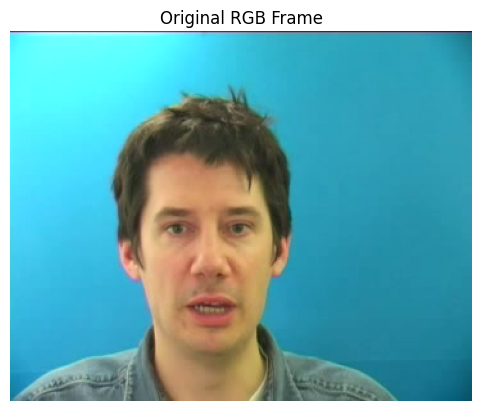

In [113]:
# Extract and display first frame
video_path = r"C:\Projects\Lip_Reading\GRID\s1\bbaf2n.mpg"

rgb_frame = load_video(video_path)[36]
image_shape = rgb_frame.shape
# isolate first frame of video for testing + dimensions

plt.imshow(rgb_frame)
plt.title("Original RGB Frame")
plt.axis(False)
plt.show()

In [114]:
# Get mesh and landmarks for frame
landmarks = get_landmarks(rgb_frame)[0]

if landmarks:
    print("Landmarks detected!")
else:
    print("No face landmarks found.")


Landmarks detected!


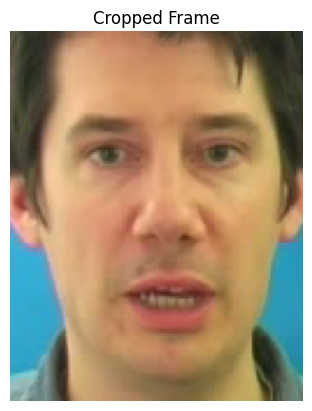

In [115]:
# Crop face only
coords = convert_landmarks_to_coordinates(landmarks, image_shape)

x_min, y_min, x_max, y_max = get_bounding_box(coords, image_shape)

cropped_frame = rgb_frame[int(y_min):int(y_max), int(x_min):int(x_max)]
plt.imshow(cropped_frame)
plt.title("Cropped Frame")
plt.axis(False)
plt.show()

In [116]:
# Get mesh and landmarks for frame
landmarks = get_landmarks(cropped_frame)[0]

if landmarks:
    print("Landmarks detected!")
else:
    print("No face landmarks found.")

Landmarks detected!


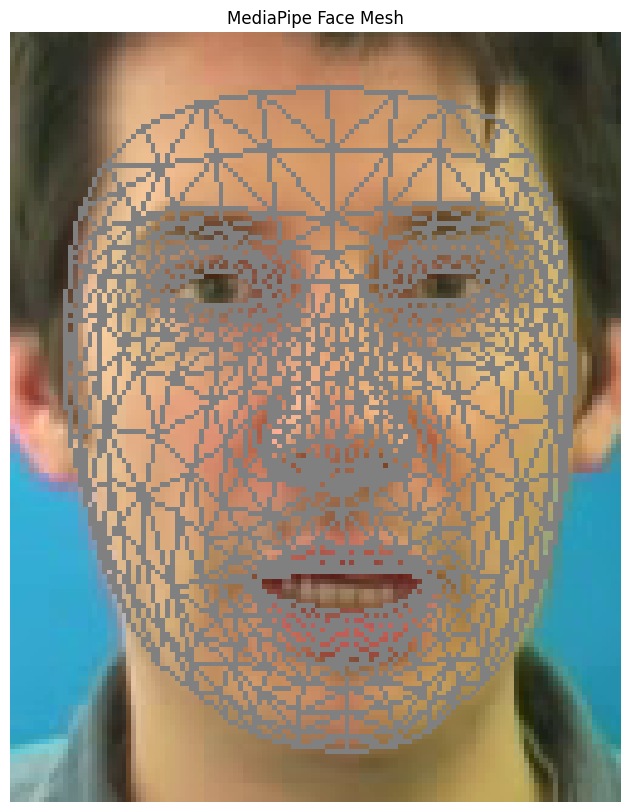

In [117]:

frame_copy = cropped_frame.copy()
landmarks = get_landmarks(cropped_frame)
if landmarks:
    for face_landmarks in landmarks:
        draw_landmarks(
            image=frame_copy,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=drawing_styles.get_default_face_mesh_tesselation_style()
        )

plt.figure(figsize=(10, 10))
plt.imshow(frame_copy)
plt.title("MediaPipe Face Mesh")
plt.axis("off")
plt.show()


In [153]:
# Isolate lip landmarks and coordinates
# Outer lips (full loop)
outer_lips = [
    61, 146, 91, 181, 84, 17,
    314, 405, 321, 375, 291, 409, 
    270, 269, 267, 0, 37, 39, 40, 185
]

# Inner lips (inside mouth opening)
inner_lips = [
    78, 191, 80, 81, 82,
    312, 311, 310, 415, 308,
    324, 318, 402, 317, 14,
    87, 178, 88, 95, 13
]

inner_mouth = [
    184, 183, 74, 42, 73, 41, 72, 38,
    11, 12, 302, 268, 303, 271, 304, 272,408,
    407, 96, 77, 89, 90, 179, 180, 86, 85, 15, 
    16, 316, 315, 403, 404, 319, 320, 325, 307
    
]

lower_jaw = [
    148, 152, 377
]
# Combine and remove duplicates
mouth_indices = list((outer_lips + inner_lips + inner_mouth + lower_jaw))
mouth_indices.sort()


landmarks = get_landmarks(cropped_frame)[0]
h, w, _ = cropped_frame.shape

mouth_coords = []
for i in mouth_indices:
    landmark = landmarks.landmark[i]
    x, y = int(landmark.x * w), int(landmark.y * h)
    mouth_coords.append((x, y))



C:\Users\ryanv\AppData\Roaming\Python\Python310\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


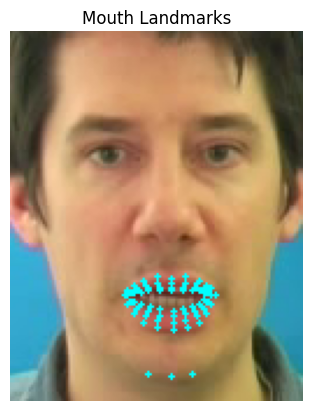

In [154]:
# Display mouth landmarks
mouth_frame = cropped_frame.copy()
for x, y in mouth_coords:
    cv2.circle(mouth_frame, (x, y), 1, (0, 255, 255), -1)

plt.imshow(mouth_frame)
plt.title("Mouth Landmarks")
plt.axis("off")
plt.show()


In [ ]:
# Measured Features
coords = convert_landmarks_to_coordinates(landmarks,(h, w))

upper_vermillion_height = landmark_dist(coords[13], coords[0])
lower_verillion_height = landmark_dist(coords[14], coords[17])

vert_distance = landmark_dist(coords[13], coords[14])
hori_distance = landmark_dist(coords[308], coords[78])
aspect_ratio = hori_distance/vert_distance

lower_jaw_distance = landmark_dist(coords[14], coords[152])

inner_mouth_area = area_of_points(inner_lips, coords)
outer_mouth_area = area_of_points(outer_lips, coords)

# add temporal landmarks and scientific - engineered landmarks

print(upper_vermillion_height, lower_verillion_height)
print(vert_distance, hori_distance, aspect_ratio)
print(lower_jaw_distance)
print(inner_mouth_area, outer_mouth_area)



4.631684511733791 8.18454116095261
8.858519483202436 35.46558867073676
28.186692061956304
